# Data Analysis - Codeforces Tag Classification

This notebook performs exploratory data analysis (EDA) on the Codeforces problem dataset.

## Objectives
- Understand the distribution of tags
- Analyze the number of tags per problem
- Examine the 8 focus tags
- Identify data quality issues
- Prepare insights for modeling

In [139]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from code_classifier.data import load_dataset_as_dataframe, DEFAULT_FOCUS_TAGS

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [140]:
# Load the dataset
df = load_dataset_as_dataframe('../data')

print(f"Total number of examples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total number of examples: 4982
Columns: ['uid', 'text', 'tags']

First few rows:


,uid,text,tags
0,591372383cf3624f69793c41370022de,"Numbers $$$1, 2, 3, \dots n$$$ (each integer f...","[greedy, constructive algorithms, math, implem..."
1,afcd41492158e68095b01ff1e88c3dd4,"There are $$$n$$$ positive integers $$$a_1, a_...","[number theory, greedy]"
2,e52ec2fa5bcf5d2027d57b0694b4e15a,You are given an undirected graph consisting o...,"[dsu, greedy, graphs]"
3,cd2519f4a7888b2c292f05c64a9db13a,A positive (strictly greater than zero) intege...,"[implementation, math]"
4,d7fe15a027750c004e4f50175e1e20d2,"Polycarp is working on a new project called ""P...",[implementation]


In [141]:
# Number of tags per example
df['n_tags'] = df['tags'].apply(len)

print("----- Basic Statistics -----")
print(f"Average number of tags per problem: {df['n_tags'].mean():.2f}")
print(f"Median number of tags: {df['n_tags'].median():.0f}")
print(f"Min tags: {df['n_tags'].min()}")
print(f"Max tags: {df['n_tags'].max()}")
print(f"\nProblems with 0 tags: {(df['n_tags'] == 0).sum()}")
print(f"Problems with 1 tag: {(df['n_tags'] == 1).sum()}")
print(f"Problems with 2 tags: {(df['n_tags'] == 2).sum()}")
print(f"Problems with 3+ tags: {(df['n_tags'] >= 3).sum()}")

----- Basic Statistics -----
Average number of tags per problem: 2.80
Median number of tags: 3
Min tags: 0
Max tags: 11

Problems with 0 tags: 41
Problems with 1 tag: 857
Problems with 2 tags: 1455
Problems with 3+ tags: 2629


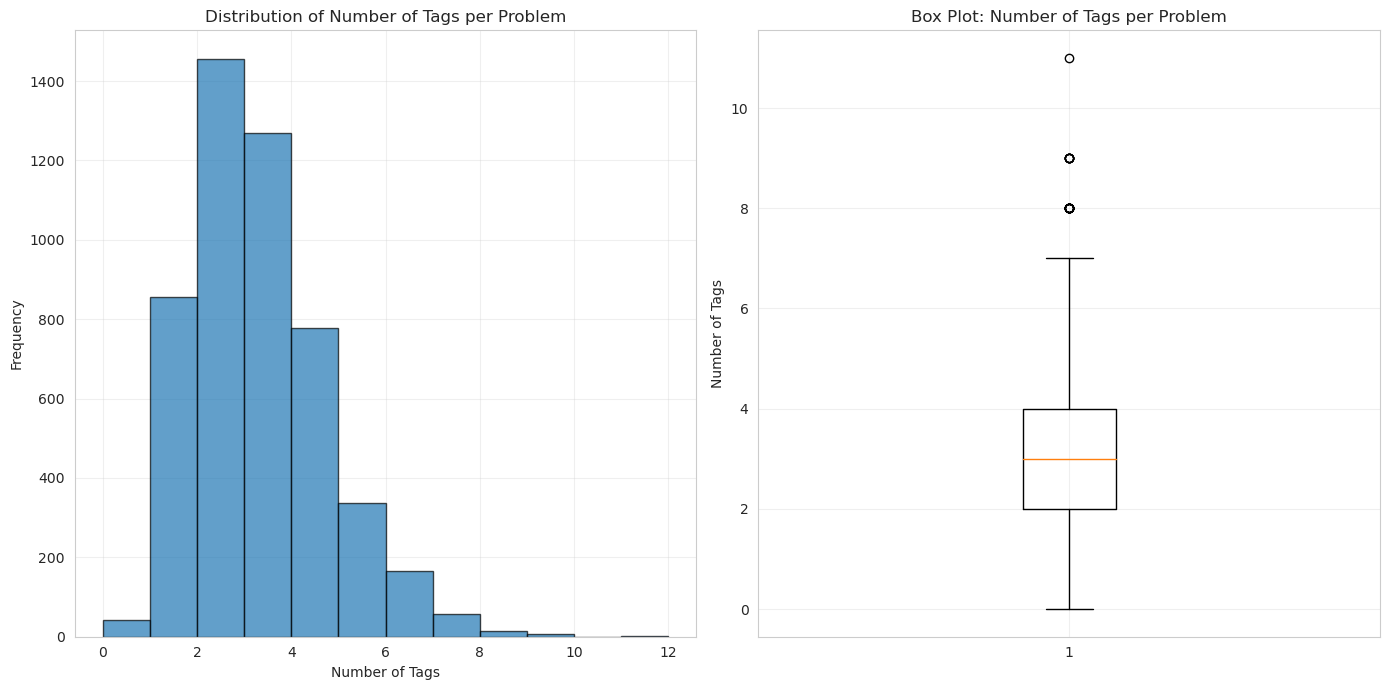

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Histogram
axes[0].hist(df['n_tags'], bins=range(0, df['n_tags'].max() + 2), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Tags')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Number of Tags per Problem')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['n_tags'], vert=True)
axes[1].set_ylabel('Number of Tags')
axes[1].set_title('Box Plot: Number of Tags per Problem')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [143]:
# Count all tags
all_tags = []
for tags in df['tags']:
    all_tags.extend(tags)

# Count tag occurrences manually
tag_counts = {}
for tag in all_tags:
    if tag in tag_counts:
        tag_counts[tag] += 1
    else:
        tag_counts[tag] = 1

print(f"Total number of unique tags: {len(tag_counts)}")
print(f"Total tag occurrences: {len(all_tags)}")

# Create DataFrame for easier analysis
# Sort tags by count (descending) - manual bubble sort
tags_sorted = []
for tag, count in tag_counts.items():
    tags_sorted.append((tag, count))

# Simple sort by count (descending)
for i in range(len(tags_sorted)):
    for j in range(i + 1, len(tags_sorted)):
        if tags_sorted[i][1] < tags_sorted[j][1]:
            tags_sorted[i], tags_sorted[j] = tags_sorted[j], tags_sorted[i]

tags_list = []
for tag, count in tags_sorted:
    tags_list.append({
        'tag': tag,
        'count': count,
        'percentage': count / len(df) * 100
    })

tags_df = pd.DataFrame(tags_list)

print("\n ------ Top 20 Most Frequent Tags ------")
print(tags_df.head(20))

Total number of unique tags: 37
Total tag occurrences: 13952

 ------ Top 20 Most Frequent Tags ------
                        tag  count  percentage
0                    greedy   1743   34.985949
1            implementation   1597   32.055399
2                      math   1409   28.281815
3   constructive algorithms   1036   20.794862
4                        dp    984   19.751104
5               brute force    837   16.800482
6           data structures    783   15.716580
7                  sortings    671   13.468487
8             binary search    567   11.380971
9                    graphs    542   10.879165
10          dfs and similar    508   10.196708
11                  strings    422    8.470494
12            number theory    350    7.025291
13                    trees    324    6.503412
14             two pointers    320    6.423123
15            combinatorics    273    5.479727
16                 bitmasks    256    5.138499
17                      dsu    176    3.532718
18  

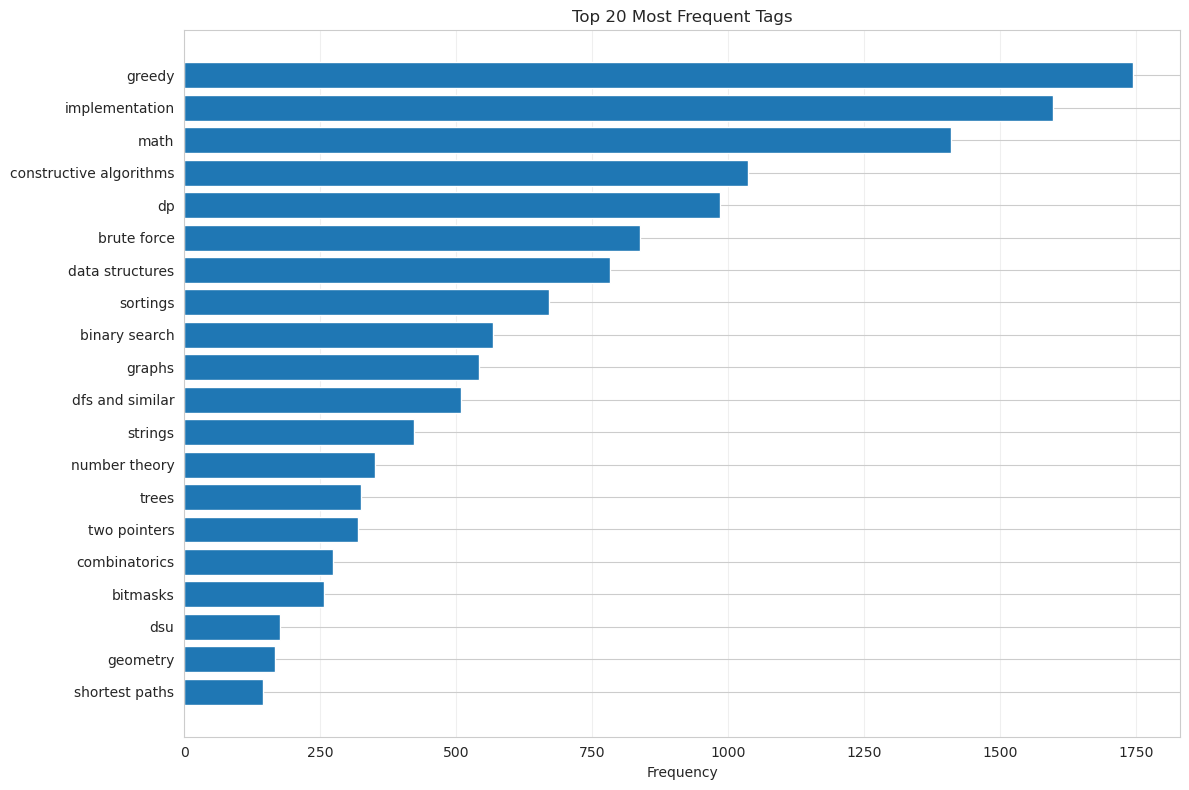

In [144]:
# Visualize top tags
top_20 = tags_df.head(20)

plt.figure(figsize=(12, 8))
y_pos = range(len(top_20))
plt.barh(y_pos, top_20['count'])
plt.yticks(y_pos, top_20['tag'])
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Tags')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [145]:
print("Focus tags:", DEFAULT_FOCUS_TAGS)
print("\n----- Focus Tags Statistics ------\n")

# Extract focus tags from the tags_df we already computed (no need to recalculate)
focus_df = tags_df[tags_df['tag'].isin(DEFAULT_FOCUS_TAGS)].copy()
focus_df = focus_df.sort_values('count', ascending=False)

print(focus_df.to_string(index=False))

Focus tags: ('math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities')

----- Focus Tags Statistics ------

          tag  count  percentage
         math   1409   28.281815
       graphs    542   10.879165
      strings    422    8.470494
number theory    350    7.025291
        trees    324    6.503412
     geometry    166    3.331995
        games    105    2.107587
probabilities     92    1.846648


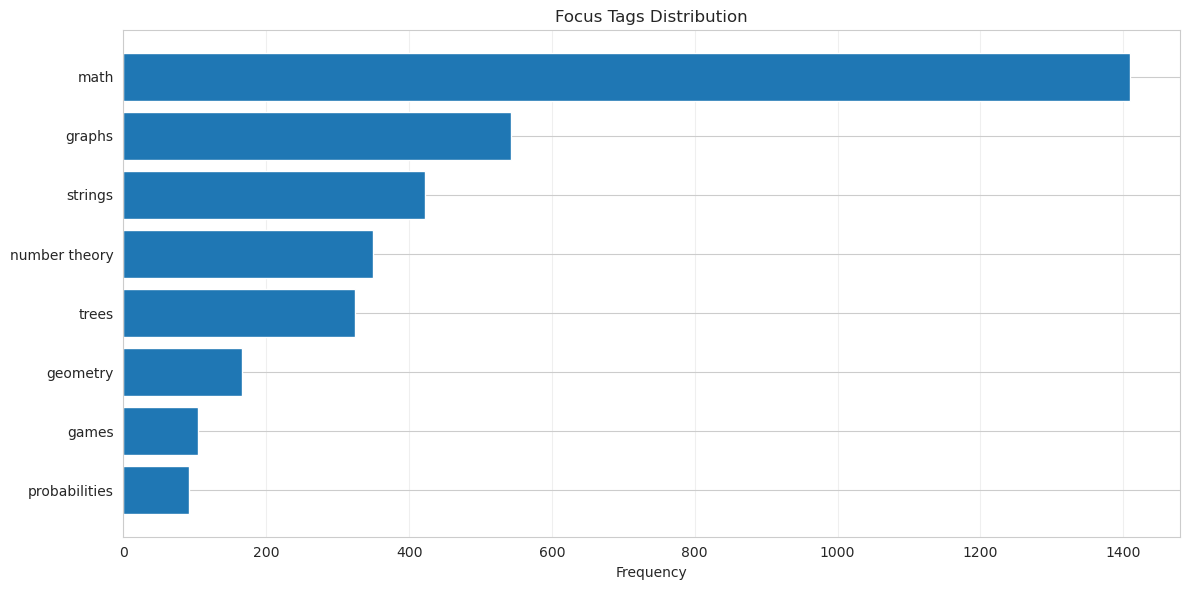

In [146]:
# Visualize focus tags
plt.figure(figsize=(12, 6))
y_pos = range(len(focus_df))
plt.barh(y_pos, focus_df['count'])
plt.yticks(y_pos, focus_df['tag'])
plt.xlabel('Frequency')
plt.title('Focus Tags Distribution')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [147]:
# How many problems have at least one focus tag?
focus_tags_set = set(DEFAULT_FOCUS_TAGS)
has_focus_tag_count = 0
for tags in df['tags']:
    if bool(set(tags) & focus_tags_set):
        has_focus_tag_count += 1

no_focus_tag_count = len(df) - has_focus_tag_count
print(f"Problems with at least one focus tag: {has_focus_tag_count} ({has_focus_tag_count / len(df) * 100:.1f}%)")
print(f"Problems with NO focus tags: {no_focus_tag_count} ({no_focus_tag_count / len(df) * 100:.1f}%)")

Problems with at least one focus tag: 2678 (53.8%)
Problems with NO focus tags: 2304 (46.2%)


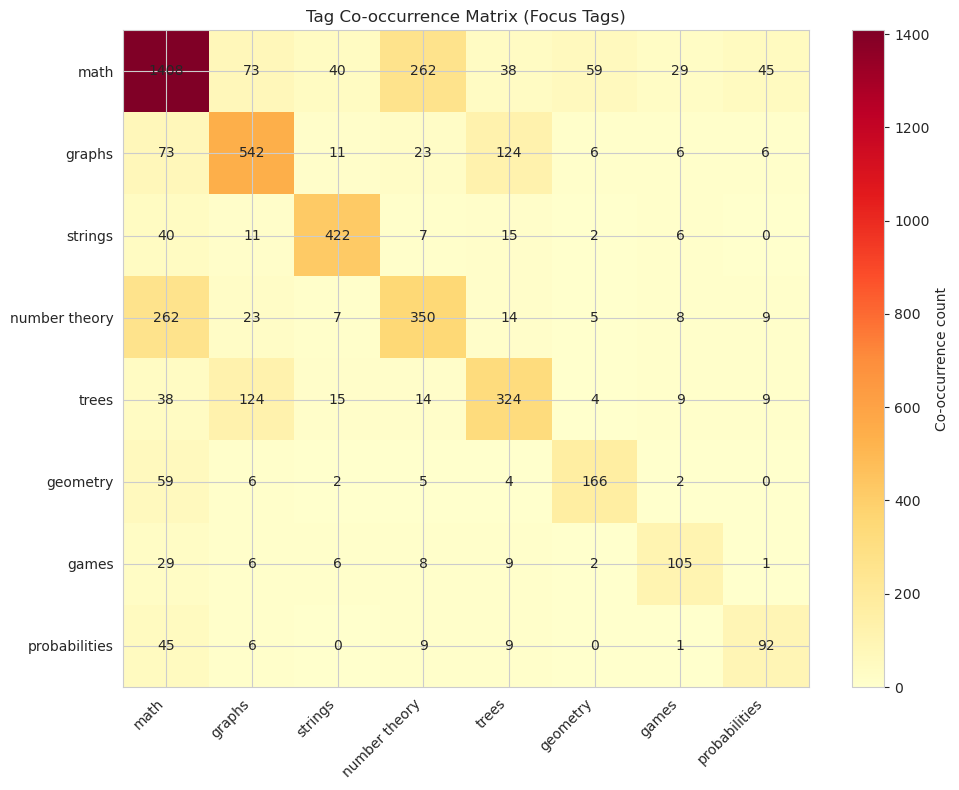

In [148]:
# Co-occurrence matrix for focus tags
n_tags = len(DEFAULT_FOCUS_TAGS)
cooccurrence = np.zeros((n_tags, n_tags))

# Count co-occurrences manually
for tags in df['tags']:
    tags_set = set(tags)
    for i in range(n_tags):
        tag1 = DEFAULT_FOCUS_TAGS[i]
        if tag1 in tags_set:
            for j in range(n_tags):
                tag2 = DEFAULT_FOCUS_TAGS[j]
                if tag2 in tags_set:
                    cooccurrence[i, j] += 1

# Create visualization
plt.figure(figsize=(10, 8))
plt.imshow(cooccurrence, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Co-occurrence count')
plt.xticks(range(n_tags), DEFAULT_FOCUS_TAGS, rotation=45, ha='right')
plt.yticks(range(n_tags), DEFAULT_FOCUS_TAGS)
plt.title('Tag Co-occurrence Matrix (Focus Tags)')

# Add text annotations
for i in range(n_tags):
    for j in range(n_tags):
        plt.text(j, i, int(cooccurrence[i, j]), ha='center', va='center')

plt.tight_layout()
plt.show()

In [149]:
# Analyze description lengths
text_lengths = []
text_word_counts = []

for text in df['text']:
    text_lengths.append(len(text))
    if text:
        word_count = len(text.split())
    else:
        word_count = 0
    text_word_counts.append(word_count)

df['text_length'] = text_lengths
df['text_word_count'] = text_word_counts

print("=== Text Statistics ===")
print(f"Average character length: {np.mean(text_lengths):.0f}")
print(f"Median character length: {np.median(text_lengths):.0f}")
print(f"Min length: {min(text_lengths)}")
print(f"Max length: {max(text_lengths)}")
print(f"\nAverage word count: {np.mean(text_word_counts):.0f}")
print(f"Median word count: {np.median(text_word_counts):.0f}")

=== Text Statistics ===
Average character length: 951
Median character length: 874
Min length: 63
Max length: 3796

Average word count: 167
Median word count: 155


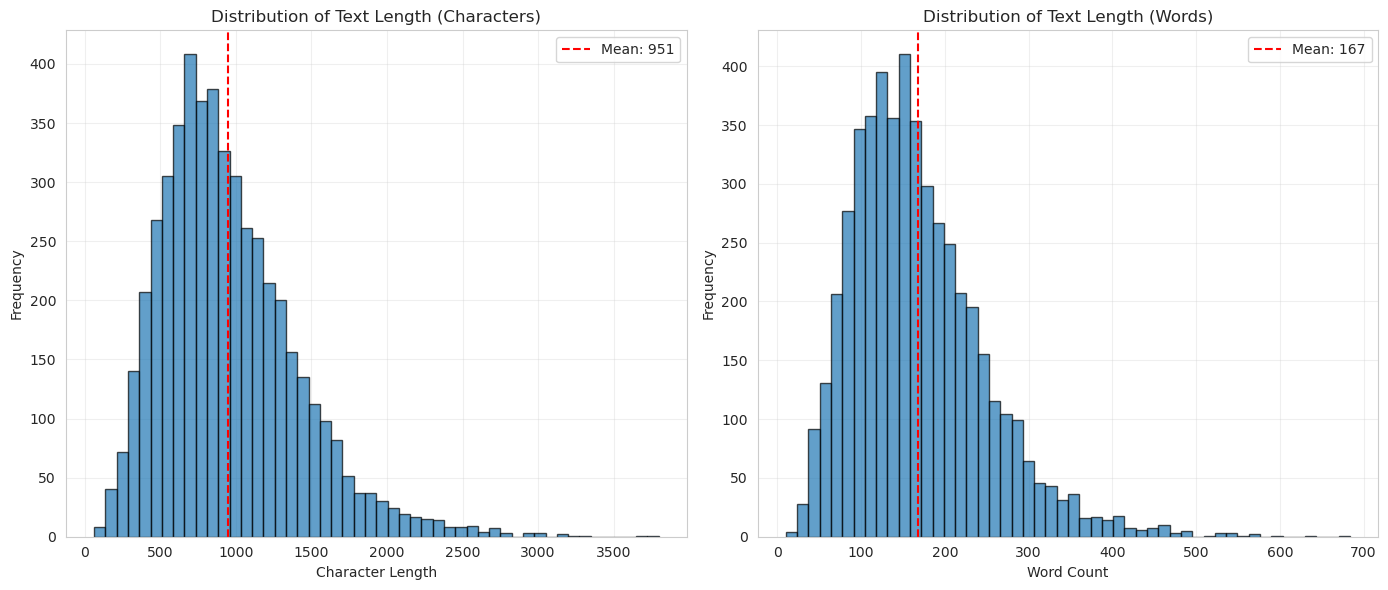

In [150]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Character length histogram
axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Text Length (Characters)')
mean_char = np.mean(text_lengths)
axes[0].axvline(mean_char, color='red', linestyle='--', label=f'Mean: {mean_char:.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Word count histogram
axes[1].hist(df['text_word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Text Length (Words)')
mean_words = np.mean(text_word_counts)
axes[1].axvline(mean_words, color='red', linestyle='--', label=f'Mean: {mean_words:.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [151]:
print("----- Data Quality Checks ------")
print(f"Problems with empty text: {(df['text'].str.len() == 0).sum()}")
print(f"Problems with empty tags: {(df['tags'].apply(len) == 0).sum()}")
print(f"Problems with duplicate UIDs: {df['uid'].duplicated().sum()}")

----- Data Quality Checks ------
Problems with empty text: 0
Problems with empty tags: 41
Problems with duplicate UIDs: 0


In [152]:
# Create a summary table
# Calculate problems with focus tags (reuse the count from earlier)
focus_tags_set = set(DEFAULT_FOCUS_TAGS)
has_focus_tag_count = 0
for tags in df['tags']:
    if bool(set(tags) & focus_tags_set):
        has_focus_tag_count += 1

summary = {
    'Metric': [
        'Total problems',
        'Unique tags',
        'Average tags per problem',
        'Problems with focus tags',
        'Average text length (chars)',
        'Average text length (words)',
    ],
    'Value': [
        len(df),
        len(tag_counts),
        f"{df['n_tags'].mean():.2f}",
        f"{has_focus_tag_count} ({has_focus_tag_count / len(df) * 100:.1f}%)",
        f"{df['text_length'].mean():.0f}",
        f"{df['text_word_count'].mean():.0f}",
    ]
}

summary_df = pd.DataFrame(summary)
print("\n=== Dataset Summary ===")
print(summary_df.to_string(index=False))


=== Dataset Summary ===
                     Metric        Value
             Total problems         4982
                Unique tags           37
   Average tags per problem         2.80
   Problems with focus tags 2678 (53.8%)
Average text length (chars)          951
Average text length (words)          167


## Key Insights for Modeling

Based on the analysis above, we can draw several insights:

1. **Class Imbalance**: Some tags are much more frequent than others. We should consider class balancing strategies.

2. **Multi-label Nature**: Most problems have 2-3 tags. This is a true multi-label classification problem.

3. **Focus Tags Coverage**: Check how well the 8 focus tags are represented in the dataset.

4. **Text Length**: Understanding text length distribution helps with feature extraction (TF-IDF parameters).

5. **Co-occurrence**: Some tags often appear together, which could inform model architecture choices.